In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import clear_output
from numpy.typing import NDArray
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

In [3]:
from qml.model.gate import get_gateset, Gate, GateInfo
from qml.model.unit import Unit, EmbedUnit, EntangleUnit
from qml.model.model import Model
from qml.tools.trainer import calc_gradients
from qml.tools.dataloader import DataLoader
from qml.optimizer.localsearch import LocalSearchOptimizer

In [4]:
%matplotlib inline
np.set_printoptions(precision=3, floatmode='fixed')

In [5]:
# settings
nq = 2
nx = 1
ng = 3
gateset = get_gateset(nq)

## Prepare dataset

In [6]:
target_func = lambda x: np.sin(np.pi * x)

In [7]:
train_xs = np.random.uniform(-1, 1, 20)
train_ys = target_func(train_xs)

test_xs = np.random.uniform(-1, 1, 20)
test_ys = target_func(test_xs)

## Build model

In [8]:
emb_unit = EmbedUnit.generate_ry_arcsin_embed_unit("emb", nq, nx, gateset=gateset)

In [9]:
tr1_units = [
    Unit.generate_random_unit(f"tr1_{i}", nq, ng, gateset=gateset)
    for i in range(6)
]

In [11]:
ent_unit = EntangleUnit.new_neighbor_cz("en1", nq, gateset=gateset)

In [14]:
models = [
    Model(nq, 1, emb_unit, [], [tr1_unit, ent_unit])
    for tr1_unit in tr1_units
]

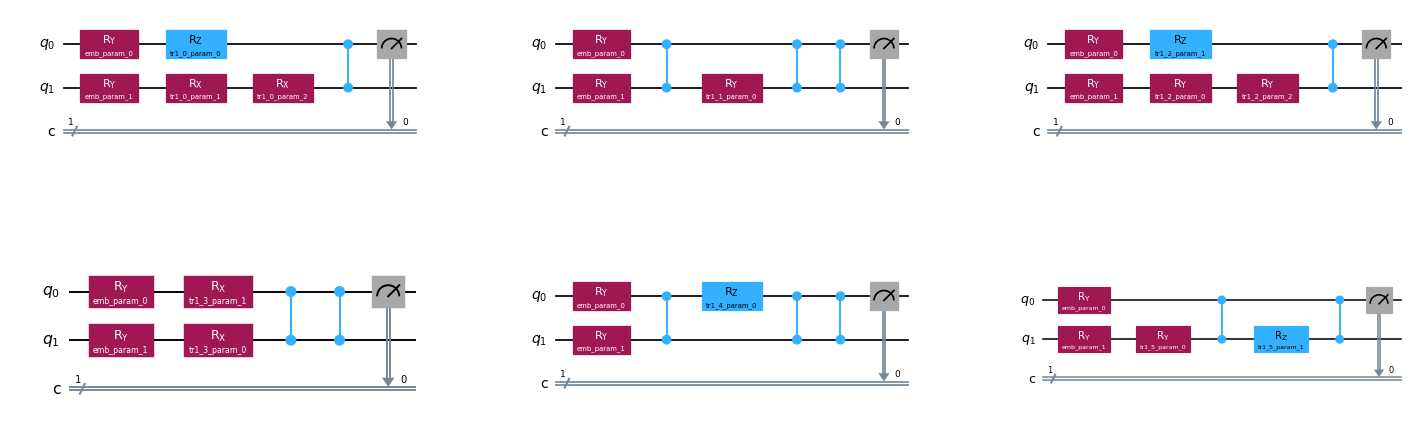

In [15]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 6))
for ax, model in zip(axes.flatten(), models):
    model.draw(ax=ax)
plt.show()

In [28]:
train_data = [train_xs, train_ys]
test_data = [test_xs, test_ys]

In [49]:
shots = 50
num_iter = 100
optim1 = LocalSearchOptimizer(train_data, test_data, shots=shots, random_search=False, single_param_update=False, variance=0.3)
optim2 = LocalSearchOptimizer(train_data, test_data, shots=shots, random_search=True,  single_param_update=False, variance=0.3)
optim3 = LocalSearchOptimizer(train_data, test_data, shots=shots, random_search=False, single_param_update=True,  variance=0.3)
optim4 = LocalSearchOptimizer(train_data, test_data, shots=shots, random_search=True,  single_param_update=True,  variance=0.3)

In [ ]:
optim = LocalSearchOptimizer()

Step:100 | Energy current:0.934  best:0.934


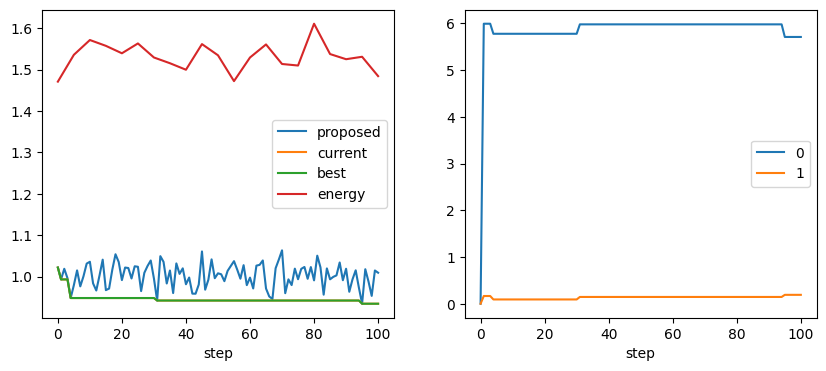

In [51]:
logs = [
    optim1.optimize(model, num_iter, shots=shots, verbose=True)
    for model in models
]

In [53]:
logs[3].result_energies

,step,proposed,current,best
0,0,1.023550,1.023550,1.023550
1,1,0.997029,0.997029,0.997029
2,2,1.035692,0.997029,0.997029
3,3,0.987588,0.987588,0.987588
4,4,0.931353,0.931353,0.931353
...,...,...,...,...
96,96,0.636265,0.519849,0.519849
97,97,0.698192,0.519849,0.519849
98,98,0.683895,0.519849,0.519849
99,99,0.608238,0.519849,0.519849


In [70]:
params = logs[3].result_variable.tail(1)
params = params.drop("step", axis=1).to_numpy().squeeze()

(array([6.21304549680272, 1.3116506540858157], dtype=object), numpy.ndarray)

In [85]:
fixed1 = model.fixed_units
fixed1[0].parameters = params

In [74]:
tr2_units = [
    Unit.generate_random_unit(f"tr2_{i}", nq, ng, gateset=gateset)
    for i in range(6)
]

In [75]:
ent_unit = EntangleUnit.new_neighbor_cz("en2", nq, gateset=gateset)

In [82]:
fixed1[0].parameter_instances

[Parameter(tr2_5_param_0), Parameter(tr2_5_param_1)]

In [83]:
for tr1_unit in tr1_units:
    print(tr1_unit.parameter_instances)

[Parameter(tr1_0_param_0), Parameter(tr1_0_param_1), Parameter(tr1_0_param_2)]
[Parameter(tr1_1_param_0)]
[Parameter(tr1_2_param_0), Parameter(tr1_2_param_1), Parameter(tr1_2_param_2)]
[Parameter(tr1_3_param_0), Parameter(tr1_3_param_1)]
[Parameter(tr1_4_param_0)]
[Parameter(tr1_5_param_0), Parameter(tr1_5_param_1)]


In [81]:
for tr2_unit in tr2_units:
    print(tr2_unit.parameter_instances)

[Parameter(tr2_0_param_0), Parameter(tr2_0_param_1), Parameter(tr2_0_param_2)]
[Parameter(tr2_1_param_0), Parameter(tr2_1_param_1)]
[Parameter(tr2_2_param_0), Parameter(tr2_2_param_1)]
[Parameter(tr2_3_param_0), Parameter(tr2_3_param_1)]
[Parameter(tr2_4_param_0)]
[Parameter(tr2_5_param_0), Parameter(tr2_5_param_1), Parameter(tr2_5_param_2)]


In [76]:
models = [
    Model(nq, 1, emb_unit, fixed1, [tr2_unit, ent_unit])
    for tr2_unit in tr2_units
]

CircuitError: "name conflict adding parameter 'tr2_5_param_0'"

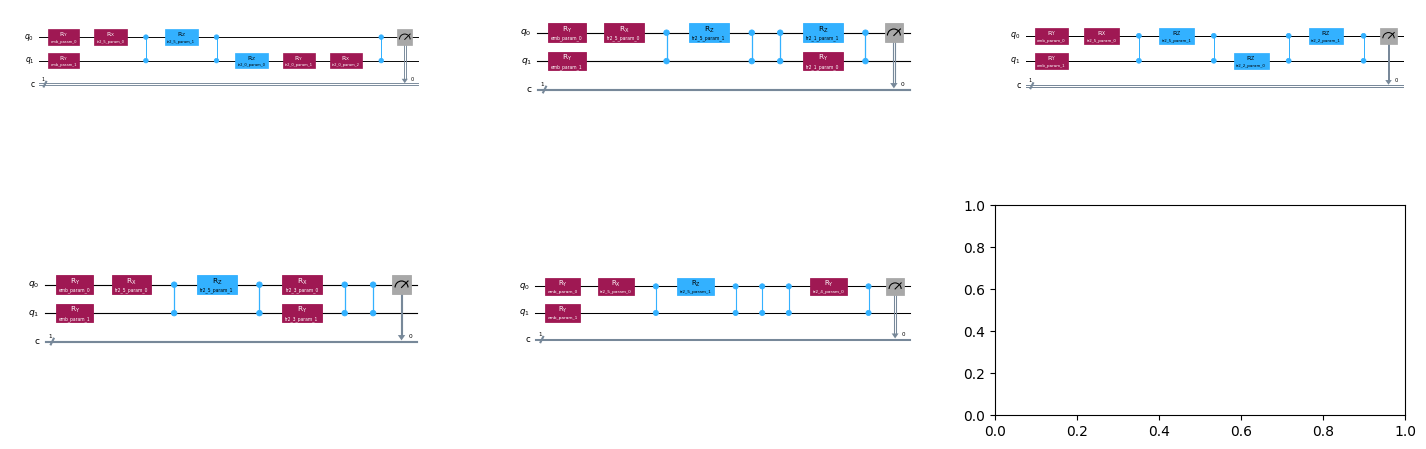

In [78]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 6))
for ax, model in zip(axes.flatten(), models):
    model.draw(ax=ax)
plt.show()

In [59]:
shots = 50
num_iter = 100
optim1 = LocalSearchOptimizer(train_data, test_data, shots=shots, random_search=False, single_param_update=False, variance=0.3)

In [60]:
logs2 = [
    optim1.optimize(model, num_iter, shots=shots, verbose=True)
    for model in models
]

KeyError: <qml.model.unit.Unit object at 0x1277944a0>